In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow import feature_column as fc 
from tensorflow.keras.datasets import boston_housing
import matplotlib.pyplot as plt

DATA_URL = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
LABEL_COLUMN = 'total_deaths'
    
file_path = tf.keras.utils.get_file("owid-covid-data.csv", DATA_URL)

TRANSFORMATION = 3

SELECT_COLUMNS = ['iso_code', 'total_cases', 'total_deaths']
DEFAULTS = ['', 0.0, 0.0]

def apply_transformation(original_value):
    return (original_value/100000)**TRANSFORMATION

def get_dataset(file_path, **kwargs):
    dataset = tf.data.experimental.make_csv_dataset(
      file_path,
      batch_size=1, # Artificially small to make examples easier to show.
      label_name=LABEL_COLUMN,
      na_value="?",
      num_epochs=1,
      ignore_errors=True, 
      shuffle=True,
      **kwargs)
    return dataset

covid_dataset = get_dataset(file_path, select_columns=SELECT_COLUMNS, column_defaults = DEFAULTS)

def convert_to_train_test_data(dataset, test_percent = 0.05):
    total_deaths = []
    transformed_total_cases = []
    total_cases = []
    for independent, dependent in dataset.as_numpy_iterator():
        if independent.get('iso_code')[0] == b'USA':
            total_deaths.append(dependent[0])
            transformed_total_cases.append([apply_transformation(independent.get('total_cases')[0])])
            total_cases.append([independent.get('total_cases')[0]])
    testRecordCount = int(round(test_percent*len(total_deaths)))
    return transformed_total_cases[testRecordCount:], total_cases[testRecordCount:], total_deaths[testRecordCount:], transformed_total_cases[:testRecordCount], total_cases[:testRecordCount], total_deaths[:testRecordCount]
    
x_train_transformed, x_train, y_train, x_test_transformed, x_test, y_test = convert_to_train_test_data(covid_dataset, test_percent=0.05)


tf.keras.backend.set_floatx('float64')
tf.__version__

features = ['total_cases']

x_train_df = pd.DataFrame(x_train, columns=features)
x_test_df = pd.DataFrame(x_test, columns=features)
y_train_df = pd.DataFrame(y_train, columns=['total_deaths'])
y_test_df = pd.DataFrame(y_test, columns=['total_deaths'])
x_train_df.head()
x_test_df.head()

feature_columns = []
for feature_name in features:
    feature_columns.append(fc.numeric_column(feature_name, dtype=tf.float32))
    
def estimator_input_fn(df_data, df_label, epochs=20, batch_size=64):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(df_data), df_label))
        ds = ds.batch(batch_size).repeat(epochs)
        return ds
    return input_function

train_input_fn = estimator_input_fn(x_train_df, y_train_df)
val_input_fn = estimator_input_fn(x_test_df, y_test_df, epochs=1)



INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'logs/covid_func/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use Varia

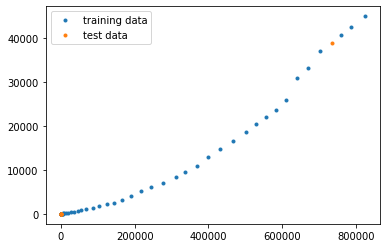

In [2]:
linear_est = tf.estimator.LinearRegressor(feature_columns=feature_columns, model_dir='logs/covid_func/', optimizer='Adam')
training = linear_est.train(train_input_fn, steps=10000)
print("training:", training)
result = linear_est.evaluate(val_input_fn)
print(result)

fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(x_train, y_train, label='training data', linewidth=0, marker='.')
ax.plot(x_test, y_test, label='test data', linewidth=0, marker='.')
ax.legend()

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from logs/covid_func/model.ckpt-40
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from logs/covid_func/model.ckpt-40
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from logs/covid_func/model.ckpt-40
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


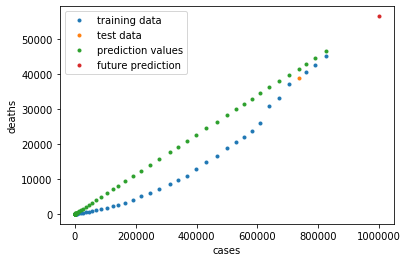

In [5]:
CASE_COUNT = 1000000
FUTURE_CASES = [CASE_COUNT]
FUTURE_CASES_TANSFORMED = [apply_transformation(CASE_COUNT)]
FUTURE_PREDICTION = []

PREDICTED_CASES = []
PREDICTED_DEATHS = []
x_train_df.head()
future_input_fn = estimator_input_fn(pd.DataFrame(FUTURE_CASES, columns=features), pd.DataFrame([0], columns=['total_deaths']), epochs=1)

pred_traning_deaths = linear_est.predict(estimator_input_fn(x_train_df, y_train_df, epochs=1))

count = 0
for pred, exp in zip(pred_traning_deaths, y_train):
    PREDICTED_CASES.append(x_train[count])
    PREDICTED_DEATHS.append(pred['predictions'][0])
    count += 1

pred_validation_deaths = linear_est.predict(estimator_input_fn(x_test_df, y_test_df, epochs=1))

count = 0
for pred, exp in zip(pred_validation_deaths, y_test):
    PREDICTED_CASES.append(x_test[count])
    PREDICTED_DEATHS.append(pred['predictions'][0])
    count += 1

pred_deaths = linear_est.predict(future_input_fn)

for pred, exp in zip(pred_deaths, FUTURE_CASES):
    FUTURE_PREDICTION.append(pred['predictions'][0])
    
fig, ax = plt.subplots()  # Create a figure and an axes.
ax.plot(x_train, y_train, label='training data', linewidth=0, marker='.')
ax.plot(x_test, y_test, label='test data', linewidth=0, marker='.')
ax.plot(PREDICTED_CASES, PREDICTED_DEATHS, label='prediction values', linewidth=0, marker='.')
ax.plot(FUTURE_CASES, FUTURE_PREDICTION, label='future prediction', linewidth=0, marker='.')
ax.set_xlabel('cases')  # Add an x-label to the axes.
ax.set_ylabel('deaths')  # Add a y-label to the axes.
ax.legend() 

